<a href="https://colab.research.google.com/github/sankichi92/satelliteBook/blob/main/notebooks/4-3-roads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-3 プランテーション林に開発された道路を抽出

[『Pythonで学ぶ衛星データ解析基礎』](https://gihyo.jp/book/2022/978-4-297-13232-3)第4章 衛星データ解析手法別演習 [解析編] より。

In [1]:
!date --rfc-3339=seconds

2023-01-02 15:19:55+00:00


In [2]:
!python --version

Python 3.8.16


In [3]:
!pip install pystac-client>=0.5.1 rioxarray>=0.13.3

In [4]:
%config InlineBackend.figure_formats = ['retina']

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

関心領域の Sentinel 2 データを検索し、もっとも被雲率の低いもののトゥルーカラー画像を確認する。

In [6]:
aoi_bbox = [109.945, 1.524, 109.973,1.548]

In [7]:
from pystac_client import Client

client = Client.open('https://earth-search.aws.element84.com/v0')
res = client.search(
  collections='sentinel-s2-l2a-cogs',
  bbox=aoi_bbox,
  datetime='2020-09-01/2020-09-20',
)
res.matched()

4

In [8]:
res.item_collection()

ID: S2B_49NCB_20200918_0_L2A
"Bounding Box: [109.36055647436756, 0.8161016697900132, 110.18933186883314, 1.8096271498522403]"
Datetime: 2020-09-18 03:07:41+00:00
created: 2020-09-18T13:43:21.894Z
sentinel:product_id: S2B_MSIL2A_20200918T024549_N0214_R132_T49NCB_20200918T063239
sentinel:sequence: 0
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 49
proj:epsg: 32649


In [9]:
item = min(res.items(), key=lambda item: item.properties['eo:cloud_cover'])
print(item.id)

from IPython.display import Image
Image(url=item.assets['thumbnail'].href)

S2B_49NCB_20200918_0_L2A


In [10]:
import rioxarray
import xarray as xr

band_names = ['B02', 'B03', 'B04', 'B08']
aoi_data = []
for band_name in band_names:
  band = rioxarray.open_rasterio(item.assets[band_name].href, chunks=True)
  band = band.rio.clip_box(*aoi_bbox, crs='EPSG:4326')
  aoi_data.append(band)

aoi_data = xr.concat(aoi_data, dim='band').assign_coords(band=band_names)
aoi_data.load()

<xarray.DataArray (band: 4, y: 267, x: 313)>
array([[[ 323,  369,  354, ...,  325,  331,  310],
        [ 307,  352,  321, ...,  319,  282,  317],
        [ 330,  361,  314, ...,  323,  310,  287],
        ...,
        [ 337,  299,  284, ...,  308,  290,  303],
        [ 336,  302,  285, ...,  303,  351,  302],
        [ 330,  302,  278, ...,  308,  418,  319]],

       [[ 586,  659,  747, ...,  608,  559,  539],
        [ 624,  650,  623, ...,  595,  532,  524],
        [ 654,  646,  600, ...,  551,  497,  486],
        ...,
        [ 738,  603,  492, ...,  476,  490,  534],
        [ 708,  662,  558, ...,  476,  509,  509],
        [ 629,  634,  563, ...,  478,  683,  590]],

       [[ 296,  324,  353, ...,  274,  279,  266],
        [ 313,  328,  306, ...,  267,  266,  269],
        [ 325,  311,  298, ...,  266,  257,  277],
        ...,
        [ 292,  272,  260, ...,  260,  280,  326],
        [ 295,  273,  240, ...,  266,  331,  305],
        [ 307,  232,  232, ...,  303,  597,  411]],

       [[3406, 3576, 3710, ..., 3592, 3572, 3356],
        [3506, 3602, 3574, ..., 3934, 3414, 3392],
        [3574, 3450, 3362, ..., 3710, 3096, 3360],
        ...,
        [4684, 4384, 4184, ..., 4016, 3960, 4074],
        [4656, 4788, 4512, ..., 4168, 4070, 4268],
        [4372, 4676, 4384, ..., 4086, 3956, 4368]]], dtype=uint16)
Coordinates:
  * band         (band) <U3 'B02' 'B03' 'B04' 'B08'
  * x            (x) float64 3.826e+05 3.826e+05 ... 3.857e+05 3.858e+05
  * y            (y) float64 1.711e+05 1.711e+05 ... 1.685e+05 1.685e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          0

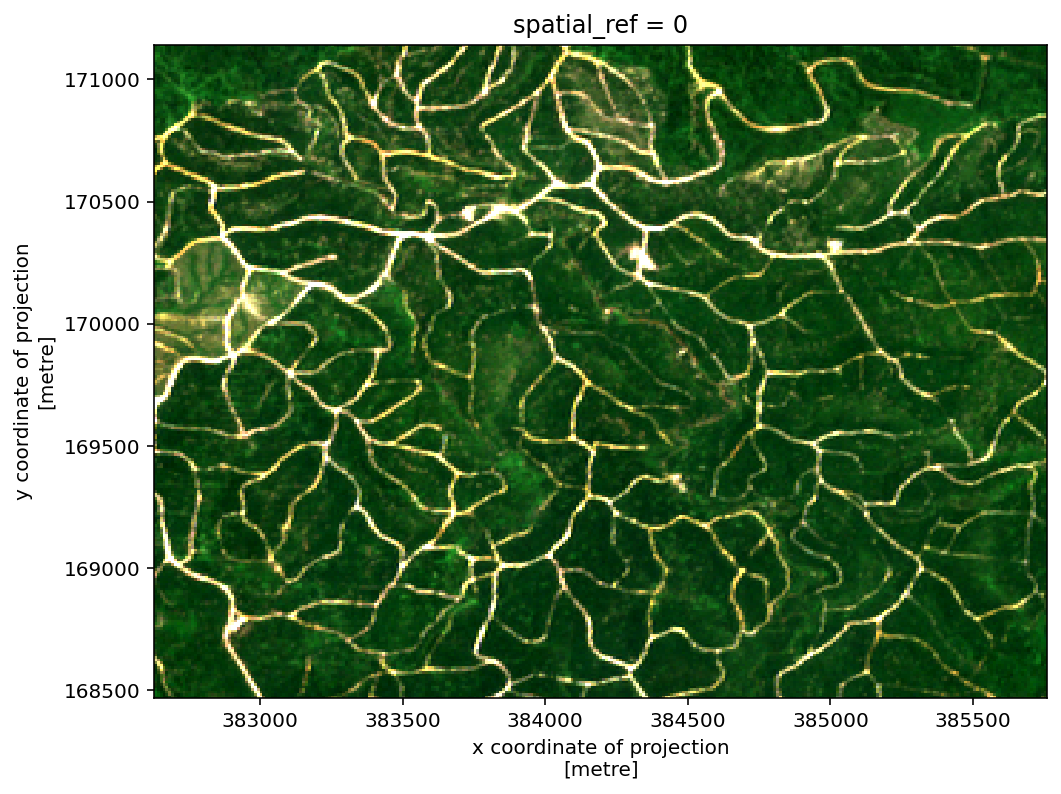

In [11]:
aoi_data.sel(band=['B04', 'B03', 'B02']).plot.imshow(rgb='band', robust=True)

NDVI を計算し、画像表示する。

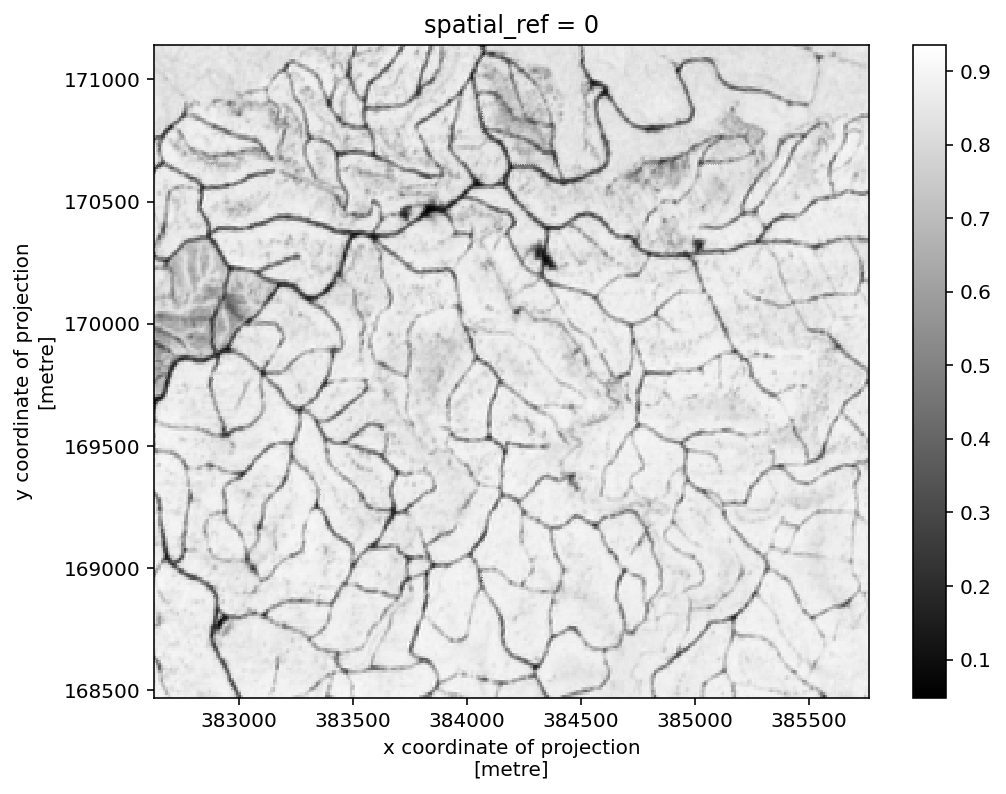

In [12]:
nir = aoi_data.sel(band='B08').astype('float64')
red = aoi_data.sel(band='B04').astype('float64')

aoi_ndvi = (nir - red) / (nir + red)
aoi_ndvi.plot(cmap='gray')

バイラテラルフィルタを適用し、エッジを残しつつ平準化する。

In [13]:
aoi_image = ((aoi_ndvi.values + 1) * 255 / 2).astype('uint8')

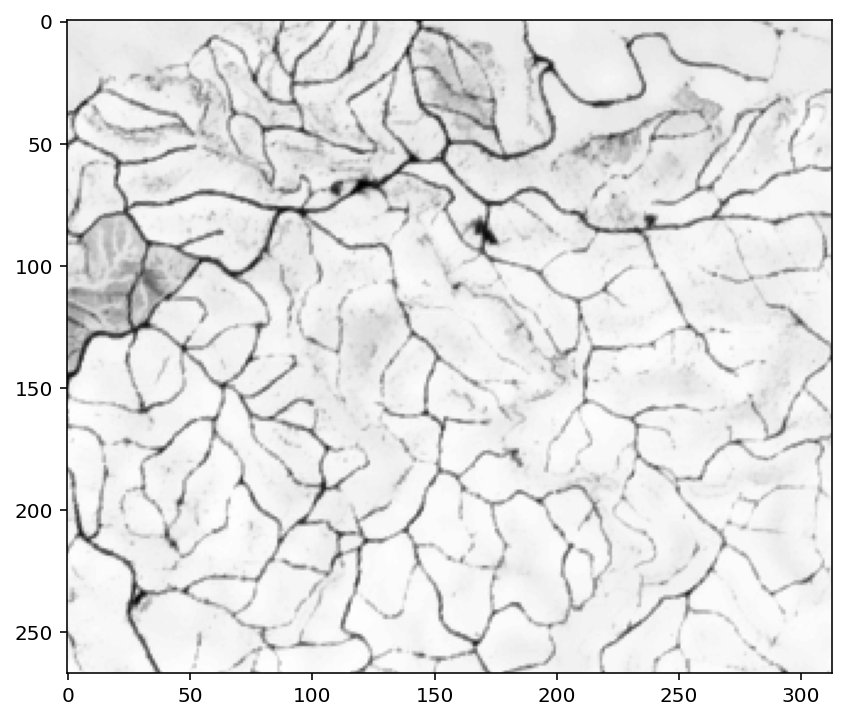

In [14]:
import cv2
filtered_image = cv2.bilateralFilter(aoi_image, 10, 5, 10)
plt.imshow(filtered_image, cmap='gray')

Canny 法でエッジを抽出する。

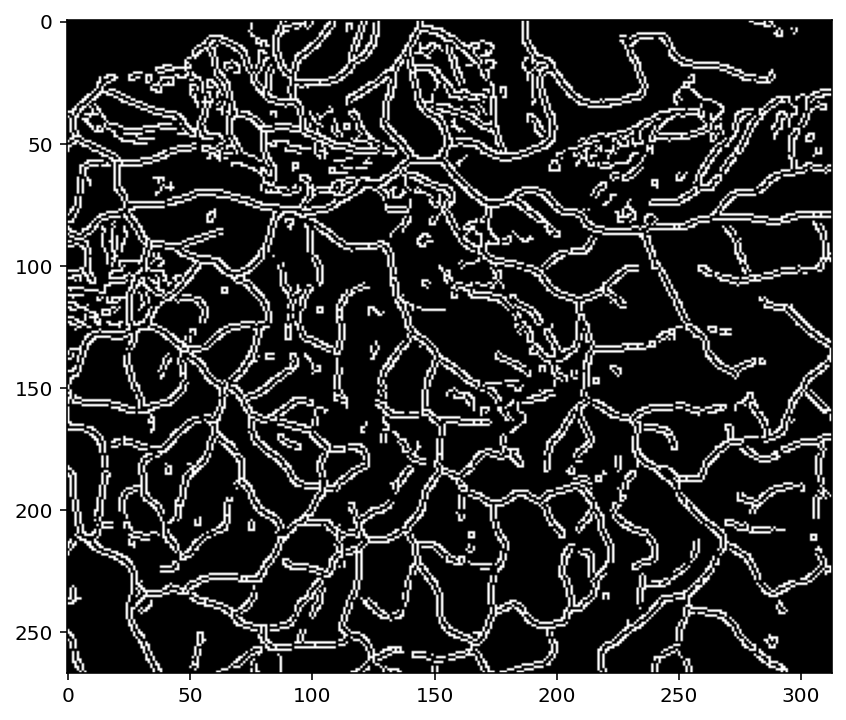

In [15]:
canny_image = cv2.Canny(aoi_image, 50, 100)
plt.imshow(canny_image, cmap='gray')

ラプラシアンフィルタでエッジ抽出する。

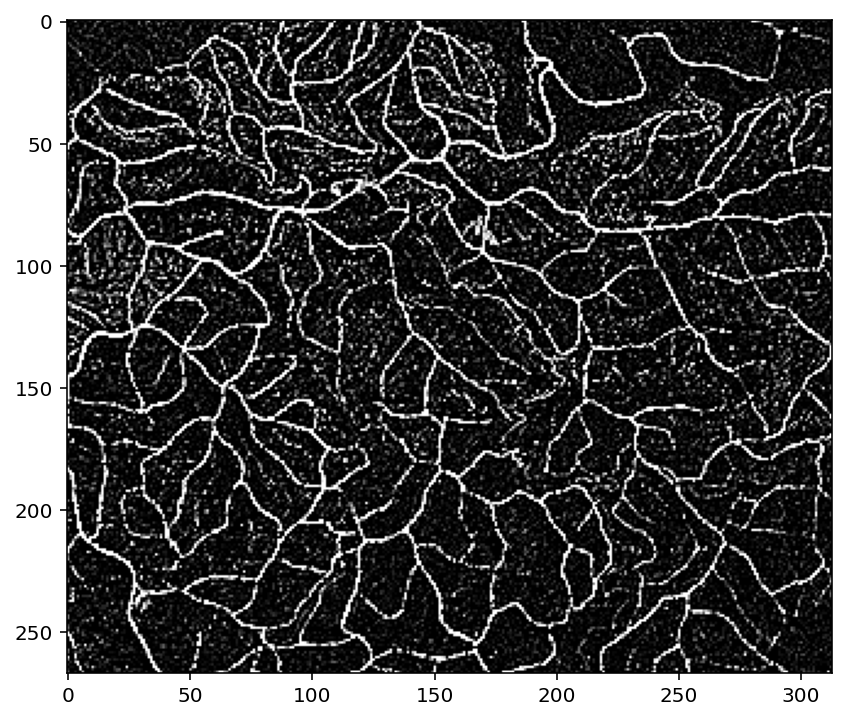

In [16]:
laplacian_image = cv2.Laplacian(aoi_image, cv2.CV_8U, scale=9)
plt.imshow(laplacian_image, cmap='gray')

`aoi_image` の値が200以下の箇所をマスクしたのち、エッジを膨張させ、より道路をはっきり抽出する。

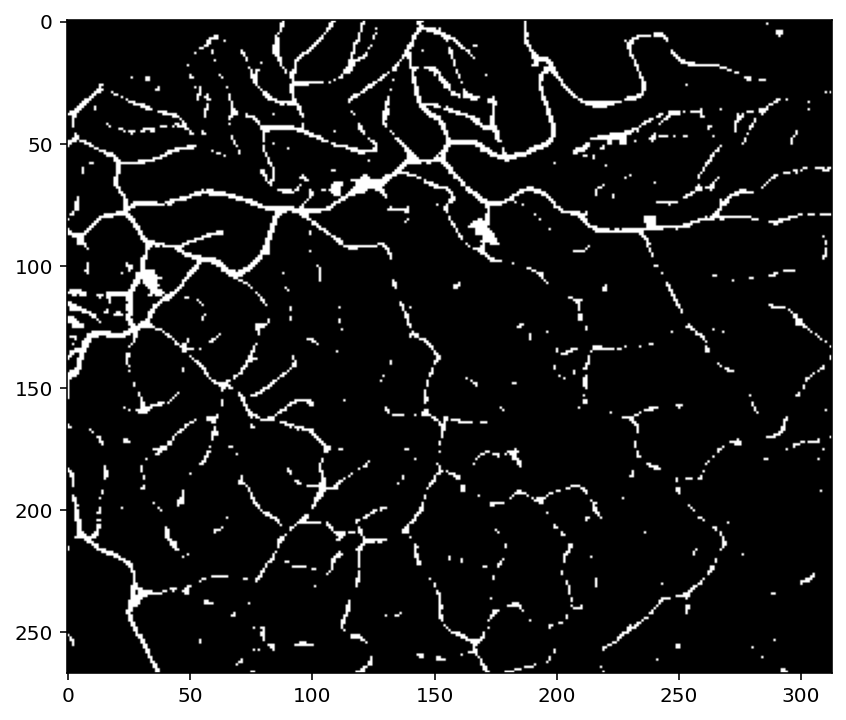

In [17]:
mask = cv2.inRange(aoi_image, 0, 200)
plt.imshow(mask, cmap='gray')

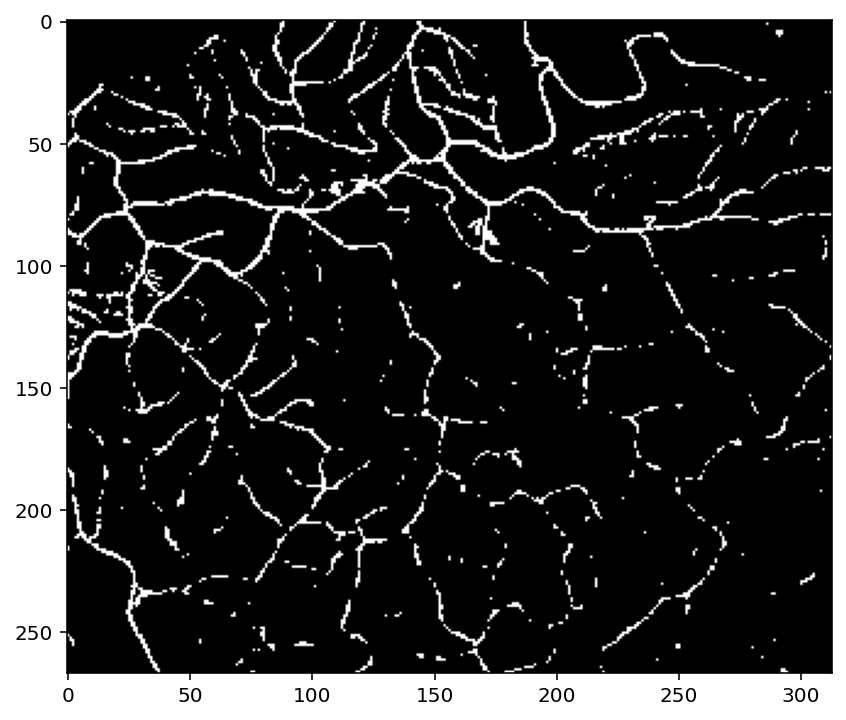

In [18]:
masked_laplacian_image = cv2.bitwise_and(laplacian_image, mask)
masked_laplacian_image = cv2.inRange(masked_laplacian_image, 30, 255)
plt.imshow(masked_laplacian_image, cmap='gray')

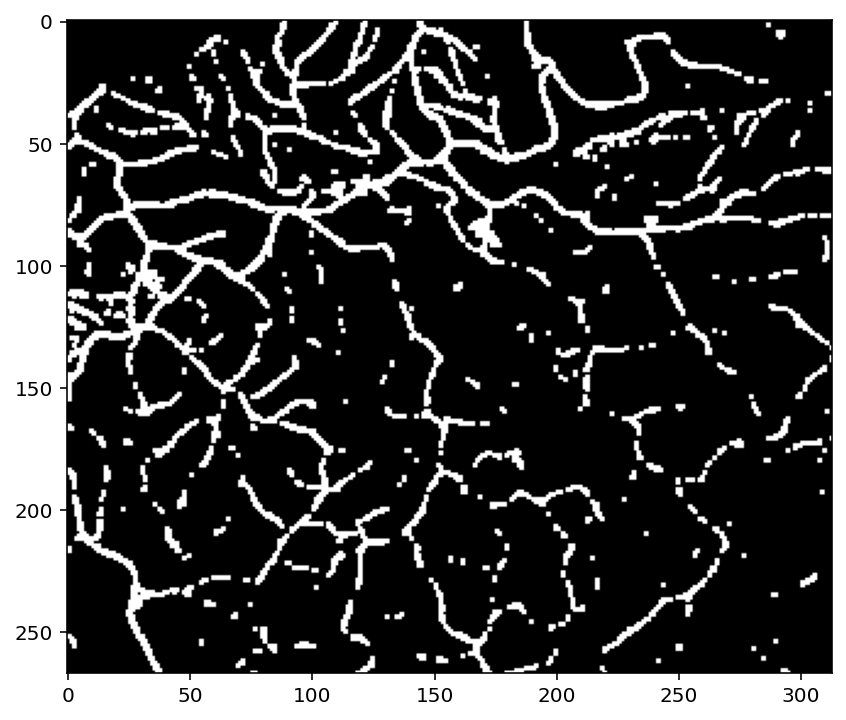

In [19]:
import numpy as np
dilated_laplacian_image = cv2.dilate(masked_laplacian_image, np.ones((2, 2)))
plt.imshow(dilated_laplacian_image, cmap='gray')

ラプラシアンフィルタの結果を赤、Canny 法の結果を緑として重ねたカラー画像を表示する。

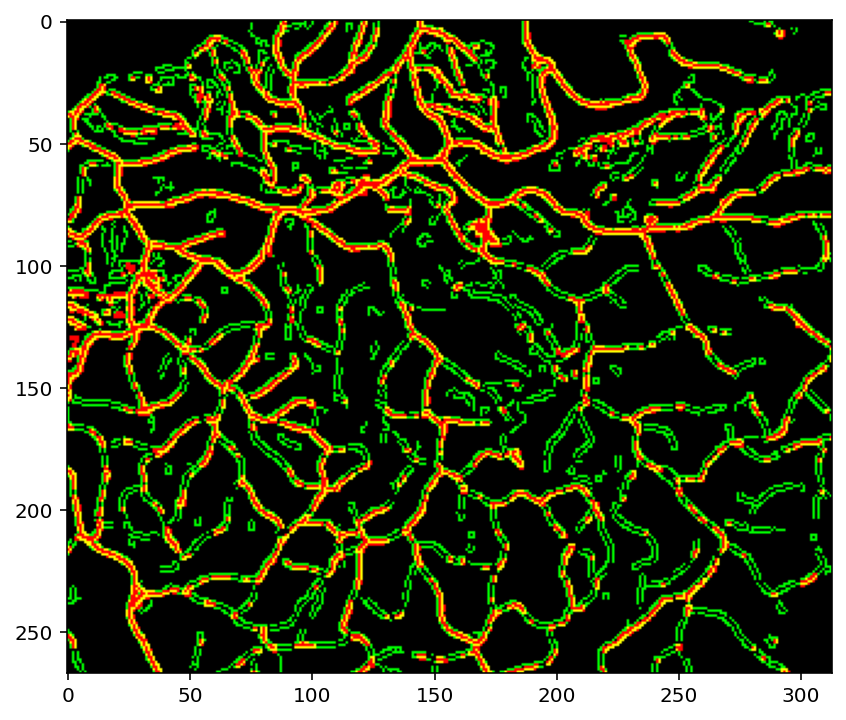

In [20]:
# https://stackoverflow.com/a/40119878
overlapped_image = np.stack(
    [
        dilated_laplacian_image,
        canny_image,
        np.zeros(aoi_image.shape, dtype=np.uint8),
    ],
    axis=-1
)
plt.imshow(overlapped_image)